In [1]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import plotly.graph_objects as go
from copy import deepcopy
import json
import torch
import torch.nn as nn
from math import sin, cos, sqrt, atan2, radians
import copy
from sklearn.cluster import *
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import geopy.distance
from scipy.spatial.distance import *
import random
import numpy as np
import osmnx as ox
import networkx as nx
from sklearn.neighbors import KDTree
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import matplotlib.pyplot as plt


import python.data as data
import python.display as dp
import python.voxels as voxel
import python.metric as metric
import python.clustering as cl
import python.RNN as RNN
#import python.learning as learning
#from python.NN import *

project_folder = "veleval_full"

display = True
plt.style.use('seaborn-whitegrid')
graph_size = (13,6)

new_distance_matrix = False

save_dbscan_oservations = False

new_voxels_clustering = False
save_voxels_clustering = False





# Data Loading

In [2]:
'''with open("files/"+project_folder+"/data_processed/osm_bikepath.df",'rb') as infile:
    df_bikepath = pickle.load(infile)'''

'with open("files/"+project_folder+"/data_processed/osm_bikepath.df",\'rb\') as infile:\n    df_bikepath = pickle.load(infile)'

In [3]:
with open("files/"+project_folder+"/data_processed/observations_matched_simplified.df",'rb') as infile:
    df_simplified = pickle.load(infile)
tab_routes_voxels_simplified, tab_routes_voxels_simplified_global, dict_voxels_simplified = voxel.generate_voxels(
    df_simplified, df_simplified.iloc[0]["route_num"], df_simplified.iloc[-1]["route_num"])
df_simplified = df_simplified[["lat", "lon", "route_num"]]

In [4]:
with open("files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df",'rb') as infile:
    df_pathfinding = pickle.load(infile)
tab_routes_voxels_pathfinding, tab_routes_voxels_pathfinding_global, dict_voxels_pathfinding = voxel.generate_voxels(
    df_pathfinding, df_pathfinding.iloc[0]["route_num"], df_pathfinding.iloc[-1]["route_num"])


# Test voxels

In [5]:
map=None
if(display):
    num_vox = -1
    tab_vox = []
    num_route = 0
    df_display = df_simplified[df_simplified["route_num"]==num_route]
    df_display["type"] = 0
    for v in tab_routes_voxels_simplified[num_route]:
        vox_str = v.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        tab_vox += voxel.get_voxel_points(vox_int, num_vox)
        num_vox -= 1

    df = pd.DataFrame(tab_vox, columns=["lat", "lon", "route_num", "type"])
    df_display = df_display.append(df)
    map = dp.display(df_display, 13, color="type")
map

<ipython-input-5-dcc5246b0ad5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_display["type"] = 0


In [6]:
if(display):

    nb_routes = 1
    min_routes = 2
    df_simplified["type"] = 0
    df_display = df_simplified[(df_simplified["route_num"]==0)]
    df_temp = df_simplified[(df_simplified["route_num"]==1)]
    df_display["route_num"] = 0
    df_temp["route_num"] = 1
    df_display = df_display.append(df_temp)
    #print(df_display)
    _, _, dict_voxels = voxel.generate_voxels(df_display, 0, 1)
    tab_vox = voxel.get_voxels_with_min_routes(dict_voxels, min_routes)
    print(len(tab_vox)/4)

    df = pd.DataFrame(tab_vox, columns=["lat", "lon", "route_num", "type"])
    df_display = df_display.append(df)
    map = dp.display(df_display, color="type") 
    #print(tab_vox)
    #print(df)
    
map

0.0


<ipython-input-6-e38bbfce121c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_display["route_num"] = 0
<ipython-input-6-e38bbfce121c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["route_num"] = 1


# Heat Maps

In [7]:
if(display):     
    tab = []
    for key in dict_voxels_simplified:
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos = voxel.get_voxel_points(vox_int, 0)
        tab.append([vox_pos[0][0], vox_pos[0][1], dict_voxels_simplified[key]["cyclability_coeff"]])

    df = pd.DataFrame(tab, columns=["lat", "lon", "Cyclability coefficient"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], zoom_start=11)
    HeatMap(data=df.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)

    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="Cyclability coefficient", size="Cyclability coefficient", zoom=11)
    fig.show()
    fig.write_image("images/heatmap_simplified.png")'''
map

In [8]:
if(display):
    tab = []
    for key in dict_voxels_pathfinding:
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos = voxel.get_voxel_points(vox_int, 0)
        tab.append([vox_pos[0][0], vox_pos[0][1], dict_voxels_pathfinding[key]["cyclability_coeff"]])

    df = pd.DataFrame(tab, columns=["lat", "lon", "Cyclability coefficient"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11)
    HeatMap(data=df[['lat', 'lon', 'Cyclability coefficient']].values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)
    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="Cyclability coefficient", size="Cyclability coefficient", zoom=11)
    fig.show()
    fig.write_image("images/heatmap_mapbox.png")'''
map

In [9]:
if(display):
    tab_routes_voxels_common = []
    dict_voxels_common = {}
    tab = []

    for i in range(len(tab_routes_voxels_pathfinding_global)):
        tab_routes_voxels_common.append(list(set(tab_routes_voxels_pathfinding_global[i]).intersection(set(tab_routes_voxels_simplified_global[i]))))

    for i in range(len(tab_routes_voxels_common)):
        for key in tab_routes_voxels_common[i]:
            if key not in dict_voxels_common:
                dict_voxels_common[key] = [i]
            else:
                dict_voxels_common[key].append(i)

    for key in dict_voxels_common:
        tab_routes = dict_voxels_common[key]
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos = voxel.get_voxel_points(vox_int, 0)
        if(len(tab_routes) >= 0):
            tab.append([vox_pos[0][0], vox_pos[0][1], len(tab_routes)])

    df = pd.DataFrame(tab, columns=["lat", "lon", "value"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11)
    HeatMap(data=df.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)
    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="value", size="value", zoom=10)
    fig.show()'''
    
#map

In [10]:
if(display):
    max_value = 0
    tab = []
    for key in dict_voxels_pathfinding:
        tab_routes = dict_voxels_pathfinding[key]["tab_routes_starting"]
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos =voxel. get_voxel_points(vox_int, 0)
        if(len(tab_routes) >= 0):
            tab.append([vox_pos[0][0], vox_pos[0][1], len(tab_routes)])
            if(len(tab_routes)>max_value):
                max_value+=1

    df = pd.DataFrame(tab, columns=["lat", "lon", "value"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11)
    HeatMap(data=df.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0.2, max_val = max_value).add_to(map)
    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="value", size="value", zoom=10)
    fig.show()'''
map

# Graphes distances

3319


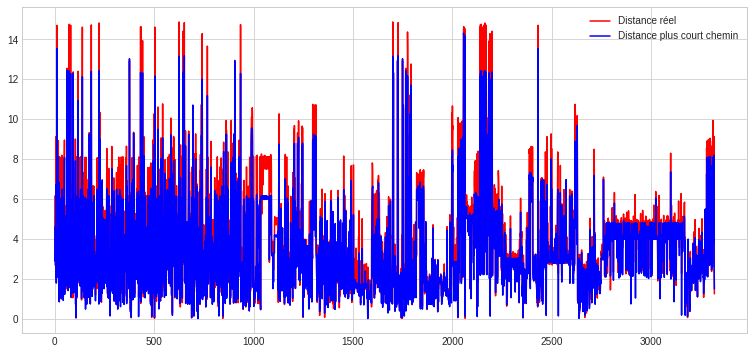

In [11]:
if(display):
    with open("files/"+project_folder+"/distances/distances_observations.tab",'rb') as infile:
        tab_distances = pickle.load(infile)    

    with open("files/"+project_folder+"/distances/distances_osmnx.tab",'rb') as infile:
        tab_distances_pf = pickle.load(infile)   

    print(len(tab_distances_pf))
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.linspace(0, len(tab_distances_pf), len(tab_distances_pf))
    plt.plot(x, tab_distances, color='red', label='Distance réel')
    plt.plot(x, tab_distances_pf, color='blue', label='Distance plus court chemin')
    
    plt.legend(loc='upper right')

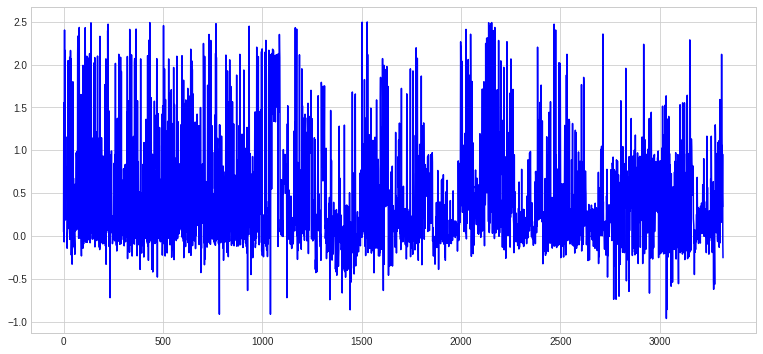

In [12]:
if(display):

    tab_distances_relatives = []
    for i in range(len(tab_distances)):
        tab_distances_relatives.append(tab_distances[i]-tab_distances_pf[i])
        
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.linspace(0, len(tab_distances_relatives), len(tab_distances_relatives))
    plt.plot(x, tab_distances_relatives, color='blue')

In [13]:
tab_neg = []
for i in range(len(tab_distances_relatives)):
    if(tab_distances_relatives[i]< -0.1):
        tab_neg.append(i)
print(len(tab_neg)/len(tab_distances_relatives)*100, "% de détours négatifs")

10.274178969569148 % de détours négatifs


# Cleaning bad routes

In [14]:
tab_num_bad_route = []
for i in range(len(tab_distances_relatives)):
    if(tab_distances_relatives[i]>= 2.5):
        #print(i)
        tab_num_bad_route.append(i)
print(len(tab_num_bad_route))

for i in range(df_pathfinding.iloc[-1]["route_num"]):
    df_temp = df_pathfinding[df_pathfinding["route_num"]==i]
    if(len(df_temp) == 1):
        if i not in tab_num_bad_route:
            tab_num_bad_route.append(i)
print(len(tab_num_bad_route))

0
0


In [15]:
for i in range(df_simplified.iloc[-1]["route_num"]):
    df_temp = df_simplified[df_simplified["route_num"]==i]
    if(len(df_temp) == 1):
        if i not in tab_num_bad_route:
            print(i)

In [16]:
num_last_route=df_simplified.iloc[-1]["route_num"]
df_simplified_saved = deepcopy(df_simplified)
df_pathfinding_saved = deepcopy(df_pathfinding)
if(num_last_route==df_pathfinding.iloc[-1]["route_num"] and len(tab_num_bad_route) > 0):
    for num_bad_route in tab_num_bad_route:
        df_simplified = df_simplified[df_simplified["route_num"] != num_bad_route]
        df_pathfinding = df_pathfinding[df_pathfinding["route_num"] != num_bad_route]
        
    df_simplified = data.clean_dataframe(df_simplified)
    df_pathfinding = data.clean_dataframe(df_pathfinding)
    
    if(df_simplified.iloc[-1]["route_num"] != df_pathfinding.iloc[-1]["route_num"] or
       df_pathfinding.iloc[-1]["route_num"] != num_last_route-len(tab_num_bad_route)):
        raise ValueError('Cleaning dataframe did not work')
    print("bite")
    with open("files/"+project_folder+"/data_processed/observations_matched_simplified.df",'wb') as outfile:
        pickle.dump(df_simplified, outfile)
    with open("files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df",'wb') as outfile:
        pickle.dump(df_pathfinding, outfile)
        
    tab_routes_voxels_simplified, tab_routes_voxels_simplified_global, dict_voxels_simplified = voxel.generate_voxels(df_simplified, df_simplified.iloc[0]["route_num"], df_simplified.iloc[-1]["route_num"])
    tab_routes_voxels_pathfinding, tab_routes_voxels_pathfinding_global, dict_voxels_pathfinding = voxel.generate_voxels(df_pathfinding, df_pathfinding.iloc[0]["route_num"], df_pathfinding.iloc[-1]["route_num"])
        

# CDF

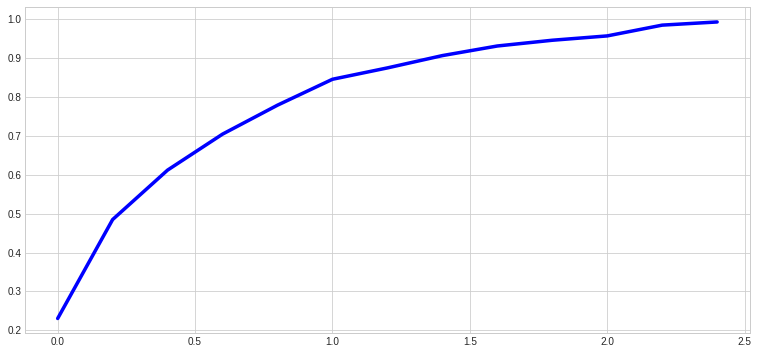

In [17]:
if(display):
    tab_distances_relatives.sort()
    tab_display = []
    tab_axis = []
    dist_max = 0
    nb_routes = 0
    for dist in tab_distances_relatives:
        if(dist > dist_max):
            tab_display.append(nb_routes/len(tab_distances_relatives))
            tab_axis.append(dist_max)
            dist_max += 0.2
        nb_routes += 1
        
        
        
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    plt.plot(tab_axis, tab_display, color='blue', linewidth=3.5)

# Matrice de distance

In [18]:
if(new_distance_matrix):
    distance_matrix = np.empty([df_simplified.iloc[-1]["route_num"]+1, df_simplified.iloc[-1]["route_num"]+1])

    pca = PCA(n_components=1)

    for i in range(df_simplified.iloc[-1]["route_num"]+1):

        for j in range(i, df_simplified.iloc[-1]["route_num"]+1):
            coeff = metric.get_distance_voxels(i, j, tab_routes_voxels_simplified_global)
            #coeff = metric.get_distance_euclidian(df_cluster[df_cluster["route_num"]==i+1], df_cluster[df_cluster["route_num"]==j+1], pca)
            #coeff = metric.get_distance_hausdorff(df_cluster[df_cluster["route_num"]==i+1], df_cluster[df_cluster["route_num"]==j+1])
            distance_matrix[i][j] = coeff[0]
            distance_matrix[j][i] = coeff[1]
    
    data.check_file("files/"+project_folder+"/clustering/distances_dbscan.mx", [])
    with open("files/"+project_folder+"/clustering/distances_dbscan.mx",'wb') as outfile:
        pickle.dump(distance_matrix, outfile)
    
else:
    with open("files/"+project_folder+"/clustering/distances_dbscan.mx",'rb') as infile:
        distance_matrix = pickle.load(infile)

print("number of non-zero in diag : ", len(np.nonzero(np.diagonal(distance_matrix))[0]))

number of non-zero in diag :  0


# Clustering configuration

In [19]:
if (project_folder == "veleval"):
    config_clustering = {"eps": 0.4, "min_samples": 5, "n_clusters_divider": 10}
elif (project_folder == "veleval_full"):
    config_clustering = {"eps": 0.35, "min_samples": 10, "n_clusters_divider": 15}
else:
    config_clustering = {"eps": 0.3, "min_samples": 10, "n_clusters_divider": 15}

# Graphes clustering

In [20]:
start_variable = 0.1
stop_variable = 0.9
step_variable = 0.1

tab_nb_clusters = []
tab_noise = []
tab_nb_mini_clusters = []
tab_nb_big_clusters = []
tab_mean = []
tab_silhouette = []

for variable in np.arange(start_variable, stop_variable, step_variable):
    c = DBSCAN(eps=variable, min_samples=config_clustering["min_samples"], metric='precomputed')
    clusters = cl.cluster(distance_matrix, c)
    dict_cluster = cl.tab_clusters_to_dict(clusters)
    silhouette = silhouette_score(distance_matrix, clusters, metric="precomputed")

    nb_mini_clusters= 0
    nb_big_clusters = 0
    mean = 0
    for i in range(len(dict_cluster)-1):
        if(len(dict_cluster[i]) > 15):
            nb_big_clusters += 1
        elif(len(dict_cluster[i]) == 1):
            nb_mini_clusters += 1
        mean+=len(dict_cluster[i])
        
    tab_nb_clusters.append(len(dict_cluster)-1)
    tab_noise.append(clusters.tolist().count(-1))
    tab_nb_mini_clusters.append(nb_mini_clusters)
    tab_nb_big_clusters.append(nb_big_clusters)
    tab_mean.append(mean/(len(dict_cluster)-1))
    tab_silhouette.append(silhouette)
    


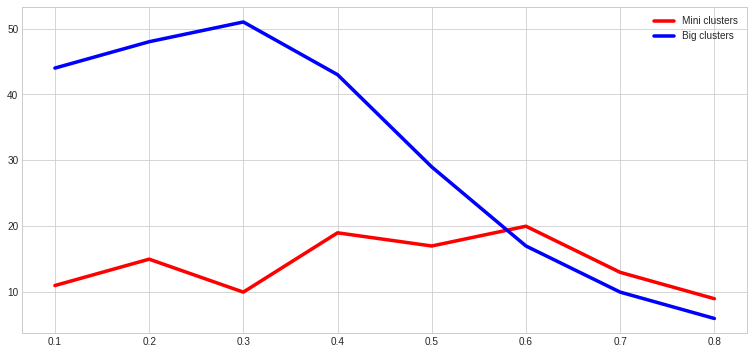

In [21]:
if(display):    
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_nb_mini_clusters, color='red', linewidth=3.5, label='Mini clusters')
    plt.plot(x, tab_nb_big_clusters, color='blue', linewidth=3.5, label='Big clusters')  
    plt.legend(loc='upper right')

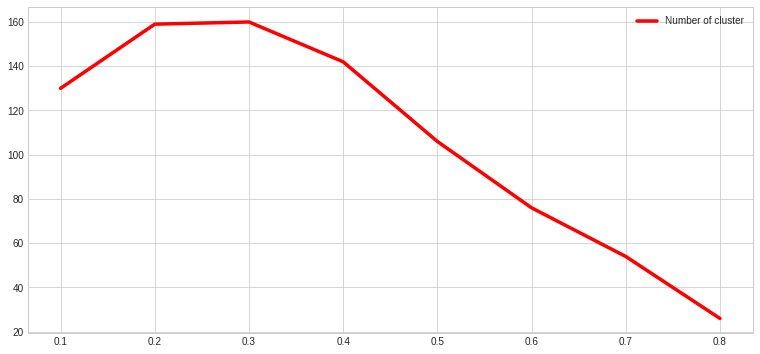

In [22]:
if(display):
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_nb_clusters, color='red', linewidth=3.5, label="Number of cluster")
    plt.legend(loc='upper right')
    data.check_file("files/"+project_folder+"/images/nb_clusters.png", [])
    plt.savefig("files/"+project_folder+"/images/nb_clusters.png")

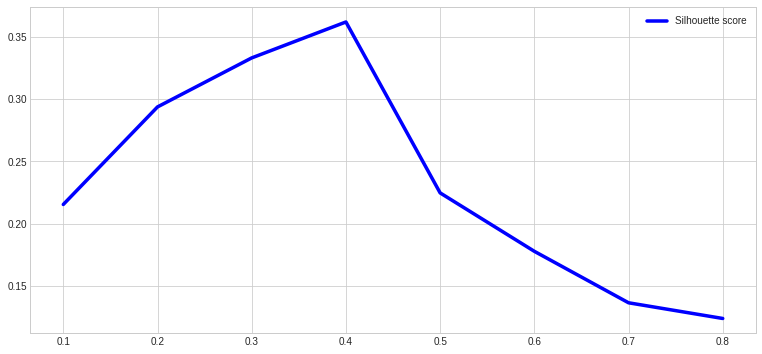

In [23]:
if(display):  
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_silhouette, color='blue', linewidth=3.5, label="Silhouette score")
    plt.legend(loc='upper right')
    plt.savefig("files/"+project_folder+"/images/silhouette.png")

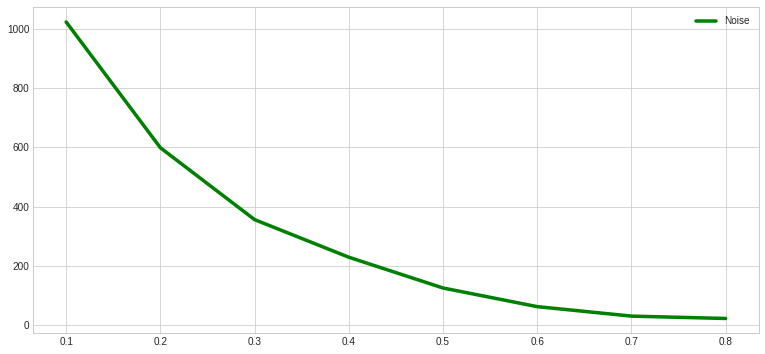

In [24]:
if(display):   
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_noise, color='green', linewidth=3.5, label="Noise")
    plt.legend(loc='upper right')
    plt.savefig("files/"+project_folder+"/images/noise.png")

# Observations Clustering

In [25]:
pca = PCA(n_components=750)
#distance_matrix_reduced = pca.fit_transform(distance_matrix)

dbscan = DBSCAN(eps=config_clustering["eps"], min_samples=config_clustering["min_samples"], metric='precomputed')
optics = OPTICS(min_samples=10, metric='precomputed')

clustering = dbscan
X = distance_matrix

tab_cluster = cl.cluster(X, clustering)
dict_cluster = cl.tab_clusters_to_dict(tab_cluster)

print(len(dict_cluster)-1, "clusters")
print("noise:", tab_cluster.tolist().count(-1))
print()
cl.cluster_properties(dict_cluster, distance_matrix, tab_cluster, "precomputed")

163 clusters
noise: 284

silhouette score : 0.3467283994511347

mean size : 18.619631901840492

11 big clusters: [2, 4, 6, 43, 7, 61, 18, 19, 33, 32, 36]
79 mini clusters : [23, 117, 31, 38, 41, 71, 47, 128, 50, 53, 56, 57, 67, 60, 62, 65, 66, 68, 70, 73, 74, 75, 76, 77, 78, 90, 79, 86, 81, 84, 85, 118, 87, 88, 91, 93, 96, 98, 99, 100, 101, 103, 136, 104, 105, 107, 106, 111, 116, 119, 130, 120, 124, 126, 127, 129, 131, 132, 133, 134, 135, 151, 138, 139, 140, 143, 144, 145, 147, 150, 149, 148, 156, 158, 157, 159, 160, 161, 162]


In [26]:
if(save_dbscan_oservations):
    print("Saving DBSCAN observations...")
    with open("files/"+project_folder+"/clustering/dbscan_observations.dict",'wb') as outfile:
        pickle.dump(dict_cluster, outfile)
    with open("files/"+project_folder+"/clustering/dbscan_observations.tab",'wb') as outfile:
        pickle.dump(tab_cluster, outfile)

In [27]:
if(display):
    num_cluster = 2
    print(len(dict_cluster[num_cluster]))
    #dp.display_routes(df_simplified, dict_cluster[nb_cluster])
    map = dp.display_cluster_heatmap(df_simplified, dict_cluster[num_cluster])
map

213


/home/lmagnana/cycling-predictive-model/python/display.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["num_route"] = i


# Voxel Clustering

In [28]:
'''clusters_used = []
for key in dict_voxels_bikepath:
    if key in dict_voxels_pathfinding:
        if(dict_voxels_bikepath[key]["cluster"] not in clusters_used):
            dict_voxels_pathfinding[key]["cluster"] = len(clusters_used)
            clusters_used.append(dict_voxels_bikepath[key]["cluster"])
        else:
            dict_voxels_pathfinding[key]["cluster"] = clusters_used.index(dict_voxels_bikepath[key]["cluster"])'''

'clusters_used = []\nfor key in dict_voxels_bikepath:\n    if key in dict_voxels_pathfinding:\n        if(dict_voxels_bikepath[key]["cluster"] not in clusters_used):\n            dict_voxels_pathfinding[key]["cluster"] = len(clusters_used)\n            clusters_used.append(dict_voxels_bikepath[key]["cluster"])\n        else:\n            dict_voxels_pathfinding[key]["cluster"] = clusters_used.index(dict_voxels_bikepath[key]["cluster"])'

In [29]:
X = []
for key in dict_voxels_pathfinding:
    if("cluster" not in dict_voxels_pathfinding[key]):
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        tab_points = voxel.get_voxel_points(vox_int)
        X.append([tab_points[0][0], tab_points[0][1], dict_voxels_pathfinding[key]["cyclability_coeff"]])
print(len(X))

17621


In [30]:
if(new_voxels_clustering):  
    kmeans = KMeans(n_clusters=len(X)//config_clustering["n_clusters_divider"], random_state=0)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = cl.cluster(X, kmeans)

else:
    with open("files/"+project_folder+"/clustering/kmeans_voxels_osmnx.sk",'rb') as infile:
        kmeans = pickle.load(infile)
    clusters = kmeans.labels_
        
dict_cluster_voxel = cl.tab_clusters_to_dict(clusters)

cl.cluster_properties(dict_cluster_voxel, X, clusters)
print(len(dict_cluster_voxel)-1, "clusters")
print("noise:", clusters.tolist().count(-1))
print()


silhouette score : 0.4547447123330236

mean size : 15.022165387894288

0 big clusters: []
1146 mini clusters : [890, 774, 334, 678, 1025, 189, 857, 44, 750, 859, 893, 385, 456, 506, 207, 792, 481, 239, 379, 515, 375, 163, 432, 266, 48, 779, 924, 551, 713, 582, 59, 344, 414, 47, 94, 765, 941, 383, 1028, 942, 719, 1098, 161, 284, 257, 631, 368, 20, 614, 1032, 871, 430, 834, 312, 548, 194, 561, 1101, 1078, 529, 540, 409, 263, 140, 349, 122, 1108, 308, 754, 293, 304, 652, 798, 666, 665, 353, 776, 167, 236, 953, 377, 1111, 142, 9, 523, 613, 138, 957, 600, 1104, 657, 259, 1146, 846, 188, 116, 119, 446, 899, 516, 692, 667, 568, 785, 581, 569, 1029, 761, 53, 729, 1040, 847, 1128, 560, 690, 626, 286, 84, 1009, 571, 227, 891, 1121, 644, 438, 634, 139, 57, 1161, 903, 645, 633, 10, 542, 894, 1016, 92, 517, 1088, 170, 115, 906, 861, 844, 33, 946, 364, 213, 592, 621, 808, 589, 616, 741, 793, 675, 208, 824, 976, 324, 1130, 646, 1027, 81, 389, 325, 1014, 100, 420, 643, 297, 387, 97, 888, 91, 1134, 479

In [31]:
if(save_voxels_clustering):
    print("Saving kmeans_voxels_osmnx.sk...")
    with open("files/"+project_folder+"/clustering/kmeans_voxels_osmnx.sk",'wb') as outfile:
        pickle.dump(kmeans, outfile)

In [32]:
if(display):

    num_cluster = 6

    tab = []
    for vox in dict_cluster_voxel[num_cluster]:
        tab.append(X[vox])

    df = pd.DataFrame(tab, columns=["lat", "lon", "value"])
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="value", size="value", zoom=10)
    fig.show()'''
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11)
    HeatMap(data=df.values.tolist(), radius=8, max_zoom=13).add_to(map)
    
map
    
    
    

In [33]:
dict_voxels_pathfinding_clustered = deepcopy(dict_voxels_pathfinding)
for c in dict_cluster_voxel:
    for vox in dict_cluster_voxel[c]:
        v = X[vox]
        vox_int = voxel.find_voxel_int([v[0], v[1]], False)
        key = str(vox_int[0])+";"+str(vox_int[1])
        dict_voxels_pathfinding_clustered[key]["cluster"] = c #len(clusters_used)+c
if(save_voxels_clustering):
    print("Saving voxels_clustered_osmnx.dict...")
    with open("files/"+project_folder+"/clustering/voxels_clustered_osmnx.dict",'wb') as outfile:
        pickle.dump(dict_voxels_pathfinding_clustered, outfile)

In [34]:
print(len(dict_voxels_pathfinding_clustered))

17621
